In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df=pd.read_csv("Hindi_train.csv")

In [ ]:

#!/usr/bin/env python
# coding: utf-8

# In[ ]:


import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]



In [ ]:
df.shape

(7957, 5)

In [ ]:
df.head()

,id,Link,Heading,Summary,Article
0,a3d72cd62e7e1b5529dd254a85fa2b5a,https://www.indiatv.in/india/national/india-su...,"भारत की बढ़ी ताकत, ‘अग्नि प्राइम’ मिसाइल का हु...",भारत ने शनिवार को ओडिशा के बालासोर तट पर ‘अग्न...,भुवनेश्वर : भारत ने शनिवार को ओडिशा के बालासोर...
1,f8904fd63c1d257dc5ee9b529df4a097,https://www.indiatv.in/india/national-covid-19...,Covid-19 Vaccination: देश में कोविड टीके की 40...,"केंद्रीय स्वास्थ्य मंत्रालय के मुताबिक, आज शाम...",नई दिल्ली। देश में कोरोना की संभावित तीसरी लहर...
2,4e89ee2300613ae0c0e8db4ed0e2c7aa,https://www.indiatv.in/india/uttar-pradesh/bjp...,यूपी में ब्राह्मण वोटरों को साधने की तैयारी कर...,"बीजेपी के केंद्र सरकार में ब्राह्मण मंत्रियों,...",बीजेपी यूपी में जनवरी के दूसरे हफ्ते से ब्राह्...
3,9a382557dc6afda0dfaf04210d16224f,https://www.indiatv.in/india/uttar-pradesh-si-...,बागपत में बिना इजाजत दाढ़ी रखने पर दरोगा सस्पे...,उत्तर प्रदेश के बागपत में बिना अनुमति के बड़ी ...,बागपत: उत्तर प्रदेश के बागपत में बिना अनुमति क...
4,928dcc9264915737630ab0e32f4a9b28,https://www.indiatv.in/india/politics-farm-law...,कृषि क़ानूनों की वापसी की घोषणा पर मैं अवाक रह...,उमा भारती ने कहा कि अगर तीन कृषि कानूनों की मह...,भोपाल: मध्य प्रदेश की पूर्व मुख्यमंत्री और बीज...


In [ ]:
print(df['Article'][0])
print(df['Summary'][0])

भुवनेश्वर : भारत ने शनिवार को ओडिशा के बालासोर तट पर ‘अग्नि प्राइम’ मिसाइल का सफल परीक्षण किया। सरकारी अधिकारियों ने इसकी जानकारी दी। अग्नि प्राइम मिसाइल अग्नि सीरीज की नए जनरेशन वाली एडवांस मिसाइल है। इसकी मारक क्षमता 1000 से 2000 किलोमीटर के बीच है। मिसाइल को रक्षा अनुसंधान और विकास संगठन (DRDO) द्वारा डिजाइन और विकसित किया गया है। अग्नि प्राइम अल्‍ट्रा मॉर्डन टेक्निक से लैस होने की वजह से बहुत हल्के वजन की मिसाइल है।आपको बता दें कि इसी सप्ताह भारत ‘सुपरसोनिक मिसाइल असिस्टेड टॉरपीडो सिस्टम’ का भी सफलतापूर्वक प्रक्षेपण किया था। इस मिसाइल का प्रक्षेपण ओडिशा तट से दूर अब्दुल कलाम द्वीप से किया गया था।
भारत ने शनिवार को ओडिशा के बालासोर तट पर ‘अग्नि प्राइम’ मिसाइल का सफल परीक्षण किया। सरकारी अधिकारियों ने इसकी जानकारी दी। अग्नि प्राइम मिसाइल अग्नि सीरीज की नए जनरेशन वाली एडवांस मिसाइल है।


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7957 entries, 0 to 7956
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       7957 non-null   object
 1   Link     7957 non-null   object
 2   Heading  7957 non-null   object
 3   Summary  7957 non-null   object
 4   Article  7957 non-null   object
dtypes: object(5)
memory usage: 310.9+ KB


In [ ]:
df.describe()

,id,Link,Heading,Summary,Article
count,7957,7957,7957,7957,7957
unique,7957,7957,7957,7922,7936
top,a3d72cd62e7e1b5529dd254a85fa2b5a,https://www.indiatv.in/india/national/india-su...,"भारत की बढ़ी ताकत, ‘अग्नि प्राइम’ मिसाइल का हु...",इंडिया टीवी डिजिटल हर जरूरी खबर को कवर करता है...,हमारे दैनिक जीवन में खबरों की बेहद महत्वपूर्ण ...
freq,1,1,1,33,14


In [ ]:
df.isnull().sum()

id         0
Link       0
Heading    0
Summary    0
Article    0
dtype: int64

In [ ]:
df['Article'][0]

'भुवनेश्वर : भारत ने शनिवार को ओडिशा के बालासोर तट पर ‘अग्नि प्राइम’ मिसाइल का सफल परीक्षण किया। सरकारी अधिकारियों ने इसकी जानकारी दी। अग्नि प्राइम मिसाइल अग्नि सीरीज की नए जनरेशन वाली एडवांस मिसाइल है। इसकी मारक क्षमता 1000 से 2000 किलोमीटर के बीच है। मिसाइल को रक्षा अनुसंधान और विकास संगठन (DRDO) द्वारा डिजाइन और विकसित किया गया है। अग्नि प्राइम अल्\u200dट्रा मॉर्डन टेक्निक से लैस होने की वजह से बहुत हल्के वजन की मिसाइल है।आपको बता दें कि इसी सप्ताह भारत ‘सुपरसोनिक मिसाइल असिस्टेड टॉरपीडो सिस्टम’ का भी सफलतापूर्वक प्रक्षेपण किया था। इस मिसाइल का प्रक्षेपण ओडिशा तट से दूर अब्दुल कलाम द्वीप से किया गया था।'

In [ ]:
import re           
from bs4 import BeautifulSoup 
from nltk.corpus import stopwords

In [ ]:
import nltk

In [ ]:
s = "मैं,मुझको,मेरा,अपने आप को,हमने,हमारा,अपना,हम,आप,आपका,तुम्हारा,अपने आप,स्वयं,वह,इसे,उसके,खुद को,कि वह,उसकी,उसका,खुद ही,यह,इसके,उन्होने,अपने,क्या,जो,किसे,किसको,कि,ये,हूँ,होता है,रहे,थी,थे,होना,गया,किया जा रहा है,किया है,है,पडा,होने,करना,करता है,किया,रही,एक,लेकिन,अगर,या,क्यूंकि,जैसा,जब तक,जबकि,की,पर,द्वारा,के लिए,साथ,के बारे में,खिलाफ,बीच,में,के माध्यम से,दौरान,से पहले,के बाद,ऊपर,नीचे,को,से,तक,से नीचे,करने में,निकल,बंद,से अधिक,तहत,दुबारा,आगे,फिर,एक बार,यहाँ,वहाँ,कब,कहाँ,क्यों,कैसे,सारे,किसी,दोनो,प्रत्येक,ज्यादा,अधिकांश,अन्य,में कुछ,ऐसा,में कोई,मात्र,खुद,समान,इसलिए,बहुत,सकता,जायेंगे,जरा,चाहिए,अभी,और,कर दिया,रखें,का,हैं,इस,होता,करने,ने,बनी,तो,ही,हो,इसका,था,हुआ,वाले,बाद,लिए,सकते,इसमें,दो,वे,करते,कहा,वर्ग,कई,करें,होती,अपनी,उनके,यदि,हुई,जा,कहते,जब,होते,कोई,हुए,व,जैसे,सभी,करता,उनकी,तरह,उस,आदि,इसकी,उनका,इसी,पे,तथा,भी,परंतु,इन,कम,दूर,पूरे,गये,तुम,मै,यहां,हुये,कभी,अथवा,गयी,प्रति,जाता,इन्हें,गई,अब,जिसमें,लिया,बड़ा,जाती,तब,उसे,जाते,लेकर,बड़े,दूसरे,जाने,बाहर,स्थान,उन्हें ,गए,ऐसे,जिससे,समय,दोनों,किए,रहती,इनके,इनका,इनकी,सकती,आज,कल,जिन्हें,जिन्हों,तिन्हें,तिन्हों,किन्हों,किन्हें,इत्यादि,इन्हों,उन्हों,बिलकुल,निहायत,इन्हीं,उन्हीं,जितना,दूसरा,कितना,साबुत,वग़ैरह,कौनसा,लिये,दिया,जिसे,तिसे,काफ़ी,पहले,बाला,मानो,अंदर,भीतर,पूरा,सारा,उनको,वहीं,जहाँ,जीधर,﻿के,एवं,कुछ,कुल,रहा,जिस,जिन,तिस,तिन,कौन,किस,संग,यही,बही,उसी,मगर,कर,मे,एस,उन,सो,अत"

In [ ]:
stop_words_hin=s.split(',')

In [ ]:
stop_words = set(stop_words_hin)
def article_cleaner(text):
    newString=text
    newString = re.sub('[!@$%&#?,.:";।]', '', newString)
    newString = re.sub(r'\([^)]*\)', '', newString)
    tokens = [w for w in newString.split() if not w in stop_words]    
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()

cleaned_article = []
for t in df['Article']:
    cleaned_article.append(article_cleaner(t))

In [ ]:
for i in range(5):
    print(cleaned_article[i])
    print()

भुवनेश्वर भारत शनिवार ओडिशा के बालासोर तट ‘अग्नि प्राइम’ मिसाइल सफल परीक्षण सरकारी अधिकारियों जानकारी दी अग्नि प्राइम मिसाइल अग्नि सीरीज नए जनरेशन वाली एडवांस मिसाइल मारक क्षमता 1000 2000 किलोमीटर के मिसाइल रक्षा अनुसंधान विकास संगठन डिजाइन विकसित अग्नि प्राइम अल्‍ट्रा मॉर्डन टेक्निक लैस वजह हल्के वजन मिसाइल हैआपको बता दें सप्ताह भारत ‘सुपरसोनिक मिसाइल असिस्टेड टॉरपीडो सिस्टम’ सफलतापूर्वक प्रक्षेपण मिसाइल प्रक्षेपण ओडिशा तट अब्दुल कलाम द्वीप

नई दिल्ली देश कोरोना संभावित तीसरी लहर संभावनाओं के कोरोना वैक्सीनेशन अधिक जोर हर दिन लाखों संख्या लोगों वैक्सीन लगाई केंद्रीय स्वास्थ्य मंत्रालय के मुताबिक शाम बजे भारत COVID वैक्सीनेशन के अंतर्गत 404467526 डोज़ लगाई यानि शनिवार 4638106 वैक्सीन डोज़ लगाई सरकार कोशिश जल्द जल्द पूरी आबादी वैक्सीनेशन जाए ताकि कोरोना नुकसान रोका सकेदेश शनिवार कोविड-19 टीके 4638 लाख अधिक खुराक दी 40 करोड़ अधिक खुराक दी चुकी स्वास्थ्य मंत्रालय शनिवार 18-44 आयु के 2118682 लाभार्थियों पहली 233019 लोगों दूसरी खुराक दी सात बजे रिपोर्ट के अनुसार ''भारत 40 करोड़ अधिक टीके लग

In [ ]:
print(df['Summary'][0])

भारत ने शनिवार को ओडिशा के बालासोर तट पर ‘अग्नि प्राइम’ मिसाइल का सफल परीक्षण किया। सरकारी अधिकारियों ने इसकी जानकारी दी। अग्नि प्राइम मिसाइल अग्नि सीरीज की नए जनरेशन वाली एडवांस मिसाइल है।


In [ ]:
def summary_cleaner(newString):
    newString = re.sub('[!#?,.:";।]', '', newString)
    newString = re.sub(r'\([^)]*\)', '', newString)
    tokens=newString.split()
    newString=''
    for i in tokens:
        newString=newString+i+' '  
    return newString

cleaned_summary = []
for t in df['Summary']:
    cleaned_summary.append(summary_cleaner(t))

In [ ]:
print(cleaned_summary[0])

भारत ने शनिवार को ओडिशा के बालासोर तट पर ‘अग्नि प्राइम’ मिसाइल का सफल परीक्षण किया सरकारी अधिकारियों ने इसकी जानकारी दी अग्नि प्राइम मिसाइल अग्नि सीरीज की नए जनरेशन वाली एडवांस मिसाइल है 


In [ ]:
for i in range(5):
    print(cleaned_summary[i])
    print()

भारत ने शनिवार को ओडिशा के बालासोर तट पर ‘अग्नि प्राइम’ मिसाइल का सफल परीक्षण किया सरकारी अधिकारियों ने इसकी जानकारी दी अग्नि प्राइम मिसाइल अग्नि सीरीज की नए जनरेशन वाली एडवांस मिसाइल है 

केंद्रीय स्वास्थ्य मंत्रालय के मुताबिक आज शाम 7 बजे तक भारत में COVID वैक्सीनेशन के अंतर्गत कुल 404467526 डोज़ लगाई गई हैं आज यानि शनिवार को 4638106 वैक्सीन डोज़ लगाई गई 

बीजेपी के केंद्र सरकार में ब्राह्मण मंत्रियों सांसद और विधायक प्रबुद्ध ब्राह्मण समाज के लोगों से घर-घर जा कर मुलाकात करेंगे छोटे बड़े सम्मेलन करेंगे 

उत्तर प्रदेश के बागपत में बिना अनुमति के बड़ी दाढ़ी रखने पर एक दरोगा को सस्पेंड कर दिया गया दरोगा को पहले भी चेतावनी दी गई थी लेकिन चेतावनी को नजरअंदाज किए जाने के बाद दरोगा पर विभाग ने कार्रवाई की 

उमा भारती ने कहा कि अगर तीन कृषि कानूनों की महत्ता प्रधानमंत्री मोदी किसानों को नहीं समझा पाए तो उसमें हम सब बीजेपी के कार्यकर्ताओं की कमी है उन्होंने यह भी कहा कि आज तक किसी भी सरकारी प्रयास से भारत के किसान संतुष्ट नहीं हुए 



In [ ]:
import numpy as np

In [ ]:
df['cleaned_article']=cleaned_article
df['cleaned_summary']=cleaned_summary
df['cleaned_summary'].replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)

In [ ]:
df

,id,Link,Heading,Summary,Article,cleaned_article,cleaned_summary
0,a3d72cd62e7e1b5529dd254a85fa2b5a,https://www.indiatv.in/india/national/india-su...,"भारत की बढ़ी ताकत, ‘अग्नि प्राइम’ मिसाइल का हु...",भारत ने शनिवार को ओडिशा के बालासोर तट पर ‘अग्न...,भुवनेश्वर : भारत ने शनिवार को ओडिशा के बालासोर...,भुवनेश्वर भारत शनिवार ओडिशा के बालासोर तट ‘अग्...,भारत ने शनिवार को ओडिशा के बालासोर तट पर ‘अग्न...
1,f8904fd63c1d257dc5ee9b529df4a097,https://www.indiatv.in/india/national-covid-19...,Covid-19 Vaccination: देश में कोविड टीके की 40...,"केंद्रीय स्वास्थ्य मंत्रालय के मुताबिक, आज शाम...",नई दिल्ली। देश में कोरोना की संभावित तीसरी लहर...,नई दिल्ली देश कोरोना संभावित तीसरी लहर संभावना...,केंद्रीय स्वास्थ्य मंत्रालय के मुताबिक आज शाम ...
2,4e89ee2300613ae0c0e8db4ed0e2c7aa,https://www.indiatv.in/india/uttar-pradesh/bjp...,यूपी में ब्राह्मण वोटरों को साधने की तैयारी कर...,"बीजेपी के केंद्र सरकार में ब्राह्मण मंत्रियों,...",बीजेपी यूपी में जनवरी के दूसरे हफ्ते से ब्राह्...,बीजेपी यूपी जनवरी के हफ्ते ब्राह्मण वोटरों साध...,बीजेपी के केंद्र सरकार में ब्राह्मण मंत्रियों ...
3,9a382557dc6afda0dfaf04210d16224f,https://www.indiatv.in/india/uttar-pradesh-si-...,बागपत में बिना इजाजत दाढ़ी रखने पर दरोगा सस्पे...,उत्तर प्रदेश के बागपत में बिना अनुमति के बड़ी ...,बागपत: उत्तर प्रदेश के बागपत में बिना अनुमति क...,बागपत उत्तर प्रदेश के बागपत बिना अनुमति के बड़...,उत्तर प्रदेश के बागपत में बिना अनुमति के बड़ी ...
4,928dcc9264915737630ab0e32f4a9b28,https://www.indiatv.in/india/politics-farm-law...,कृषि क़ानूनों की वापसी की घोषणा पर मैं अवाक रह...,उमा भारती ने कहा कि अगर तीन कृषि कानूनों की मह...,भोपाल: मध्य प्रदेश की पूर्व मुख्यमंत्री और बीज...,भोपाल मध्य प्रदेश पूर्व मुख्यमंत्री बीजेपी नेत...,उमा भारती ने कहा कि अगर तीन कृषि कानूनों की मह...
...,...,...,...,...,...,...,...
7952,479587ad084896edc43fc167d93bbcf3,https://www.indiatv.in/india/national-kashmir-...,सेना के जेसीओ की बहादुरी के आगे आतंकियों के मं...,बुधवार की दोपहर 2 बजे श्रीनगर-बारामूला का नेशन...,श्रीनगर. स्वतंत्रता दिवस नजदीक है। पाकिस्तान स...,श्रीनगर स्वतंत्रता दिवस नजदीक पाकिस्तान समर्थि...,बुधवार की दोपहर 2 बजे श्रीनगर-बारामूला का नेशन...
7953,4180e390188587b625eddd9ec8617026,https://www.indiatv.in/india/politics-p-chidam...,"मोदी सरकार जो उपदेश दुनिया को देती है, उस पर प...","चिदंरबम ने ट्वीट किया, ""जी-7 आउटरीच बैठक में प...",नई दिल्ली. कांग्रेस के वरिष्ठ नेता पी चिदंबरम ...,नई दिल्ली कांग्रेस के वरिष्ठ नेता पी चिदंबरम ज...,चिदंरबम ने ट्वीट किया जी-7 आउटरीच बैठक में प्र...
7954,f6ddbba150187bf43197d7d53a06a591,https://www.indiatv.in/india/national-9346-chi...,देश में कोरोना से 9346 बच्चे बेसहारा और अनाथ ह...,NCPCR ने वकील स्वरूपमा चतुर्वेदी के जरिए दायर ...,नई दिल्ली: राष्ट्रीय बाल अधिकार संरक्षण आयोग (...,नई दिल्ली राष्ट्रीय बाल अधिकार संरक्षण आयोग मं...,NCPCR ने वकील स्वरूपमा चतुर्वेदी के जरिए दायर ...
7955,919b1f8e832738cd4225aa63c2d7d5eb,https://www.indiatv.in/india/uttar-pradesh/up-...,UP: BJP ने रमापति शास्त्री को बनाया प्रोटेम स्...,गोंडा के मनकापुर सीट से भाजपा विधायक शास्त्री ...,लखनऊः उत्तर प्रदेश की राज्यपाल आनंदीबेन पटेल न...,लखनऊः उत्तर प्रदेश राज्यपाल आनंदीबेन पटेल बुधव...,गोंडा के मनकापुर सीट से भाजपा विधायक शास्त्री ...


In [ ]:
for i in range(5):
    print("Article:",df['cleaned_article'][i])
    print("Summary:",df['cleaned_summary'][i])
    print("\n")

Article: भुवनेश्वर भारत शनिवार ओडिशा के बालासोर तट ‘अग्नि प्राइम’ मिसाइल सफल परीक्षण सरकारी अधिकारियों जानकारी दी अग्नि प्राइम मिसाइल अग्नि सीरीज नए जनरेशन वाली एडवांस मिसाइल मारक क्षमता 1000 2000 किलोमीटर के मिसाइल रक्षा अनुसंधान विकास संगठन डिजाइन विकसित अग्नि प्राइम अल्‍ट्रा मॉर्डन टेक्निक लैस वजह हल्के वजन मिसाइल हैआपको बता दें सप्ताह भारत ‘सुपरसोनिक मिसाइल असिस्टेड टॉरपीडो सिस्टम’ सफलतापूर्वक प्रक्षेपण मिसाइल प्रक्षेपण ओडिशा तट अब्दुल कलाम द्वीप
Summary: भारत ने शनिवार को ओडिशा के बालासोर तट पर ‘अग्नि प्राइम’ मिसाइल का सफल परीक्षण किया सरकारी अधिकारियों ने इसकी जानकारी दी अग्नि प्राइम मिसाइल अग्नि सीरीज की नए जनरेशन वाली एडवांस मिसाइल है 


Article: नई दिल्ली देश कोरोना संभावित तीसरी लहर संभावनाओं के कोरोना वैक्सीनेशन अधिक जोर हर दिन लाखों संख्या लोगों वैक्सीन लगाई केंद्रीय स्वास्थ्य मंत्रालय के मुताबिक शाम बजे भारत COVID वैक्सीनेशन के अंतर्गत 404467526 डोज़ लगाई यानि शनिवार 4638106 वैक्सीन डोज़ लगाई सरकार कोशिश जल्द जल्द पूरी आबादी वैक्सीनेशन जाए ताकि कोरोना नुकसान रोका सकेदेश शन

In [ ]:
import matplotlib.pyplot as plt

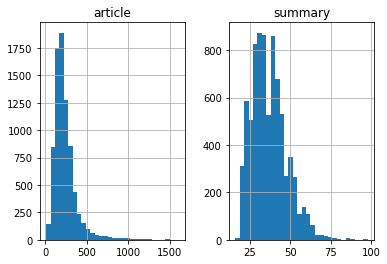

In [ ]:
article_word_count = []
summary_word_count = []

for i in df['cleaned_article']:
      article_word_count.append(len(i.split()))

for i in df['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'article':article_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [ ]:
cnt=0
for i in df['cleaned_article']:
    if(len(i.split())<=210):
        cnt=cnt+1
print(cnt/len(df['cleaned_article']))

cnt=0
for i in df['cleaned_summary']:
    if(len(i.split())<=36):
        cnt=cnt+1
print(cnt/len(df['cleaned_summary']))

0.5399019731054417
0.5317330652255875


In [ ]:
max_len_article=210
max_len_summary=36

In [ ]:
cleaned_article =np.array(df['cleaned_article'])
cleaned_summary=np.array(df['cleaned_summary'])

short_article=[]
short_summary=[]

for i in range(len(cleaned_article)):
    if(len(cleaned_summary[i].split())<=max_len_summary and len(cleaned_article[i].split())<=max_len_article):
        short_article.append(cleaned_article[i])
        short_summary.append(cleaned_summary[i])
        
df1=pd.DataFrame({'article':short_article,'summary':short_summary})

In [ ]:
df1.shape

(2429, 2)

In [ ]:
df1['summary'] = df1['summary'].apply(lambda x : 'START '+ x + ' END')

In [ ]:
df1=df1[:1000]
df1.shape

(1000, 2)

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df1['article']),np.array(df1['summary']),test_size=0.1,random_state=0,shuffle=True) 

In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.utils import pad_sequences

In [ ]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
x_tokenizer.word_counts

OrderedDict([('नई', 392),
             ('दिल्ली', 726),
             ('लखनऊ', 156),
             ('के', 9914),
             ('राजधानी', 78),
             ('कोरोना', 622),
             ('हॉस्पिटल', 9),
             ('चौथी', 5),
             ('मंजिल', 11),
             ('कूदकर', 3),
             ('मरीज', 85),
             ('जान', 72),
             ('दे', 120),
             ('दी', 591),
             ('शख्स', 27),
             ('किडनी', 5),
             ('गंभीर', 65),
             ('समस्या', 20),
             ('जूझ', 10),
             ('इलाज', 104),
             ('वो', 80),
             ('संक्रमित', 148),
             ('हाल', 71),
             ('आई', 77),
             ('दूसरी', 105),
             ('रिपोर्ट', 94),
             ('पॉजिटिव', 44),
             ('निकली', 7),
             ('जिसके', 109),
             ('उसने', 54),
             ('कदम', 38),
             ('उठा', 15),
             ('जानकारी', 333),
             ('मुताबिक', 228),
             ('मरने', 34),
             ('वाला', 62),


In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for k,v in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+v
    if(v<thresh):
        cnt=cnt+1
        freq=freq+v
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 72.69761752198987
Total Coverage of rare words: 13.151464257884902


In [ ]:
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_len_article, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_len_article, padding='post')

x_voc   =  x_tokenizer.num_words + 1

In [ ]:
x_voc

4688

In [ ]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for k,v in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+v
    if(v<thresh):
        cnt=cnt+1
        freq=freq+v
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 86.70531787285086
Total Coverage of rare words: 24.727715677844657


In [ ]:
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

y_tr    =   pad_sequences(y_tr_seq, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_len_summary, padding='post')

y_voc  =   y_tokenizer.num_words +1

In [ ]:
y_voc

666

In [ ]:
y_tokenizer.word_counts

OrderedDict([('start', 900),
             ('शख्स', 6),
             ('पहले', 44),
             ('से', 464),
             ('ही', 53),
             ('किडनी', 1),
             ('की', 741),
             ('गंभीर', 3),
             ('समस्या', 5),
             ('जूझ', 5),
             ('रहा', 56),
             ('था', 67),
             ('इसी', 8),
             ('के', 1383),
             ('इलाज', 7),
             ('दौरान', 47),
             ('वो', 4),
             ('कोरोना', 113),
             ('भी', 107),
             ('संक्रमित', 25),
             ('हो', 159),
             ('गया', 130),
             ('end', 900),
             ('सोनिया', 3),
             ('गांधी', 36),
             ('ऐसे', 8),
             ('समय', 19),
             ('दिल्ली', 77),
             ('बाहर', 11),
             ('जा', 47),
             ('रही', 55),
             ('है', 628),
             ('जब', 15),
             ('बिहार', 7),
             ('चुनाव', 29),
             ('में', 913),
             ('कांग्रेस', 46),
        

In [ ]:
y_tokenizer.word_counts['start'],len(y_tr)

(900, 900)

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# !pip install Attention

# !pip install keras-self-attention

In [ ]:
# !pip install AttentionLayer

In [ ]:
# !pip install keras-attention

In [ ]:
from keras import backend as K 
K.clear_session()

In [ ]:
# from import AttentionLayer

In [ ]:
latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_len_article,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 210)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 210, 100)     468800      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 210, 300),   481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=256, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
4/4 [==============================] - 249s 53s/step - loss: 5.6931 - val_loss: 4.3310
Epoch 2/50
4/4 [==============================] - 214s 48s/step - loss: 3.9181 - val_loss: 3.7338
Epoch 3/50
4/4 [==============================] - 207s 51s/step - loss: 3.6287 - val_loss: 3.5055
Epoch 4/50
4/4 [==============================] - 207s 50s/step - loss: 3.4978 - val_loss: 3.5027
Epoch 5/50
4/4 [==============================] - 220s 52s/step - loss: 3.5137 - val_loss: 3.4781
Epoch 6/50
4/4 [==============================] - 212s 52s/step - loss: 3.4544 - val_loss: 3.4430
Epoch 7/50
4/4 [==============================] - 208s 50s/step - loss: 3.4270 - val_loss: 3.4336
Epoch 8/50
4/4 [==============================] - 199s 48s/step - loss: 3.4008 - val_loss: 3.3889
Epoch 9/50
4/4 [==============================] - 214s 51s/step - loss: 3.3649 - val_loss: 3.4117
Epoch 10/50
4/4 [==============================] - 209s 49s/step - loss: 3.3734 - val_loss: 3.3611
Epoch 11/50
4/4 [==

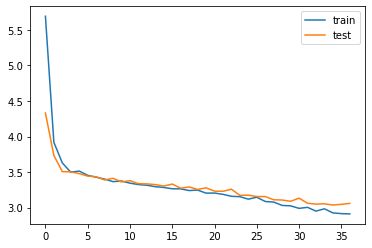

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_article,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end'  or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0,100):
    print("Article:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_len_article)))
    print("\n")

Article: नई दिल्ली लखनऊ के राजधानी कोरोना हॉस्पिटल चौथी मंजिल कोरोना मरीज जान दे दी शख्स किडनी गंभीर समस्या जूझ के इलाज के वो कोरोना संक्रमित हाल आई दूसरी कोरोना रिपोर्ट पॉजिटिव निकली जिसके उसने कदम उठा जानकारी के मुताबिक मरने वाला सीतापुर जिले रहने वाला जिसका नाम किशोर 32 साल युवक पिछले किडनी गंभीर इलाज करा शख्स किडनी चुकी थीं पीजीआई चल शख्स किडनी इलाज अगस्त 2018 चल हाल इलाज के कोरोना 16 अप्रैल रिपोर्ट पॉजिटिव आई जिसके अस्पताल भर्ती कोरोना किडनी इलाज जारी हाल कोरोना टेस्ट पॉजिटिव जिसके उसने कदम उठा मिली जानकारी के मुताबिक 29 तारीख खिड़की उसने लगा दी तुरंत इमरजेंसी ले जाया जहां डॉक्टर नहीं बचा सके पुलिस मामला दर्ज हैउत्तर प्रदेश कोरोना के नये मामलों बढ़त देखने मिल प्रदेश जगहों कोरोना सबसे असर दिख उसमें राजधानी लखनऊ शामिल बीते दिन राहत बात कोरोना संक्रमित वालों संख्या के मुकाबले संक्रमण मुक्त वालों संख्या बुधवार कोरोना करीब 30 हजार लोग संक्रमित हालांकि करीब 36 हजार कोरोना मुक्त 
Original summary: शख्स पहले से ही की से रहा था इसी के इलाज के दौरान कोरोना से भी संक्रमित हो गया 
1/1 [======

In [ ]:
# text="स्जिनके द्वारा उनकी लेखन कला को आंका जाता है."
# print("Predicted summary:",decode_sequence(text[:max_len_article]))

In [ ]:
# print(type(x_tr[0]))

<class 'numpy.ndarray'>


In [ ]:
# import pickle

In [ ]:
# def fun1(text):
#   # cleaned_text=article_cleaner(text)
#   # df=pd.DataFrame({'article': cleaned_text})
#   # cleaned_text=np.array(df['article'])
#   # # cleaned_text=cleaned_text.apply(lambda x: 'START' + x + ' END')
#   # x_tr=np.array(df['article'])
#   # x_tokenizer.fit_on_text(list(x_tr))
#   # cleaned_text_seq=x_tokenizer.texts_to_sequences(x_tr)
#   # cleaned_text=pad_sequences(cleaned_text_seq,maxlen=max_len_article,padding='post')
#   summary=decode_sequence(text)
#   return summary


In [ ]:
# fun1(text)

IndexError: ignored